In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
# #######################################
# ### Generic gradient checker
# def generic_gradient_checker(X, y, theta, objective_func, gradient_func, 
#                              epsilon=0.01, tolerance=1e-4):
#     """
#     The functions takes objective_func and gradient_func as parameters. 
#     And check whether gradient_func(X, y, theta) returned the true 
#     gradient for objective_func(X, y, theta).
#     Eg: In LSR, the objective_func = compute_square_loss, and gradient_func = compute_square_loss_gradient
#     """
#     #TODO
    


#######################################


def load_data():
    #Loading the dataset
    print('loading the dataset')

    df = pd.read_csv('ridge_regression_dataset.csv', delimiter=',')
    X = df.values[:,:-1]
    y = df.values[:,-1]

    print('Split into Train and Test')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=10)
    print("Scaling all to [0, 1]")
    X_train, X_test = feature_normalization(X_train, X_test)
    X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
    X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))
    return X_train, y_train, X_test, y_test

In [3]:
#######################################
### Feature normalization
def feature_normalization(train, test):
    """Rescale the data so that each feature in the training set is in
    the interval [0,1], and apply the same transformations to the test
    set, using the statistics computed on the training set.

    Args:
        train - training set, a 2D numpy array of size(num_instances, num_features)
        test - test set, a 2D numpy array of size(num_instances, num_features)

    Returns:
        train_normalized - training set after normalization
        test_normalized - test set after normalization
    """
    #Initialize return variables
    train_normalized, test_normalized = [] , []
    #Iterate over 2D array 
    for d in range(train.shape[1]):
        #Grab subsets
        train_temp = train[:,d]
        test_temp = test[:,d]
        train_min = train_temp.min()
        train_max = train_temp.max()
        #If the column is not filled with constants, we want to include them
        if len(np.unique(train_temp)) > 1:
            #Grab the columns, transform, and append to list (implicitly making them rows)
            train_normalized.append((train_temp - train_min) / (train_max - train_min))
            test_normalized.append((test_temp - train_min) / (train_max - train_min))
            
    #Reformat data type to np.array and Transpose so rows become columns
    train_normalized, test_normalized = np.array(train_normalized).T, np.array(test_normalized).T  
    #Return values
    return train_normalized, test_normalized

In [4]:
X_train, y_train, X_test, y_test = load_data()
# X_train, X_test = feature_normalization(x_train, x_test)

loading the dataset
Split into Train and Test
Scaling all to [0, 1]


In [5]:
#######################################
### The square loss function
def compute_square_loss(X, y, theta, stoch_flag =False):
    """
    Given a set of X, y, theta, compute the average square loss for predicting y with X*theta.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D array of size(num_features)

    Returns:
        loss - the average square loss, scalar
    """
    y_hat = X@theta
    loss = (y_hat - y)**2
    
    if stoch_flag == False:
        
        return sum(loss)/len(y)
    
    else:
        return loss

In [6]:
#######################################
### The gradient of the square loss function
def compute_square_loss_gradient(X, y, theta, stoch_flag = False):
    """
    Compute the gradient of the average square loss(as defined in compute_square_loss), at the point theta.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)

    Returns:
        grad - gradient vector, 1D numpy array of size(num_features)
    """
    if stoch_flag == True:
        
        grad = (2/X.shape[0])*(X.T@X@theta - X.reshape(X.shape[1]).T*y)
        
    else:
        grad = (2/X.shape[0])*(X.T@X@theta - X.T@y)
    
    return grad

In [7]:
#######################################
### Gradient checker
#Getting the gradient calculation correct is often the trickiest part
#of any gradient-based optimization algorithm. Fortunately, it's very
#easy to check that the gradient calculation is correct using the
#definition of gradient.
#See http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization
def grad_checker(X, y, theta, epsilon=0.01, tolerance=1e-4):
    """Implement Gradient Checker
    Check that the function compute_square_loss_gradient returns the
    correct gradient for the given X, y, and theta.

    Let d be the number of features. Here we numerically estimate the
    gradient by approximating the directional derivative in each of
    the d coordinate directions:
(e_1 =(1,0,0,...,0), e_2 =(0,1,0,...,0), ..., e_d =(0,...,0,1))

    The approximation for the directional derivative of J at the point
    theta in the direction e_i is given by:
(J(theta + epsilon * e_i) - J(theta - epsilon * e_i)) /(2*epsilon).

    We then look at the Euclidean distance between the gradient
    computed using this approximation and the gradient computed by
    compute_square_loss_gradient(X, y, theta).  If the Euclidean
    distance exceeds tolerance, we say the gradient is incorrect.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)
        epsilon - the epsilon used in approximation
        tolerance - the tolerance error

    Return:
        A boolean value indicating whether the gradient is correct or not
    """
    ### Given Code:
    true_gradient = compute_square_loss_gradient(X, y, theta) #The true gradient
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate
  
    ### My Code:
    epsilons = np.array([epsilon]*num_features)
 
    for i in range(num_features):
     
        ei = np.zeros(num_features)  
        ei[i] = epsilon
        
        partial = (compute_square_loss(X,y,theta+(ei)) - (compute_square_loss(X,y,theta-(ei)) )) / (2 * epsilon)
      
        approx_grad[i] = partial
    
    difference = np.sqrt(sum((approx_grad - true_gradient)**2))
    
    if difference > tolerance:
        return False 
    else:
        return True 

In [8]:
#######################################
### Batch gradient descent
def batch_grad_descent(X, y, alpha=0.1, num_step=1000, grad_check=False):
    """
    In this question you will implement batch gradient descent to
    minimize the average square loss objective.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - step size in gradient descent
        num_step - number of steps to run
        grad_check - a boolean value indicating whether checking the gradient when updating

    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size(num_step+1, num_features)
                     for instance, theta in step 0 should be theta_hist[0], theta in step(num_step) is theta_hist[-1]
        loss_hist - the history of average square loss on the data, 1D numpy array,(num_step+1)
    """
    ### Given Code:
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_step + 1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_step + 1)  #Initialize loss_hist
    theta = np.zeros(num_features)  #Initialize theta
    ### My Code:
    
    loss_hist[0] = compute_square_loss(X,y,theta)
    theta_hist[0,:] = theta
    
    for i in range(1,num_step+1):
       
        grad = compute_square_loss_gradient(X,y,theta)
        theta = theta - (alpha * grad)
        loss_hist[i] = compute_square_loss(X,y,theta)
        theta_hist[i,:] = theta
        
    return theta_hist, loss_hist

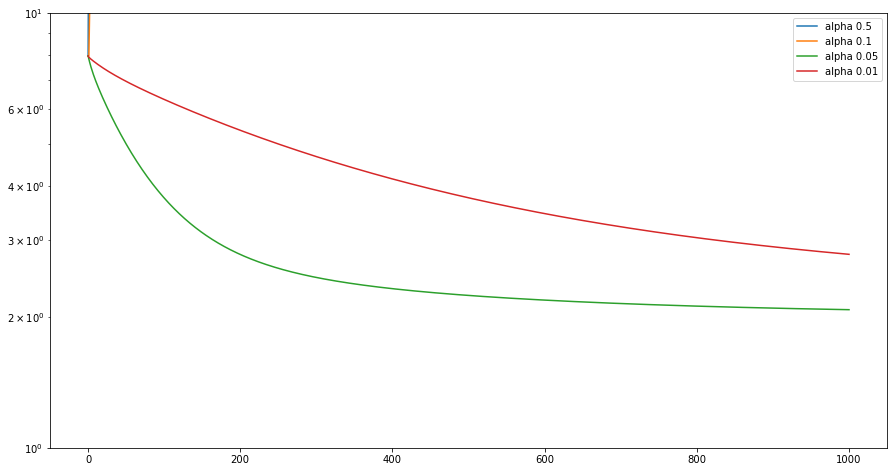

In [9]:
alpha_array = [0.5,0.10,.05,0.01]
graph_dict = dict()
step_array = list(range(1001))

for alpha in alpha_array:
    graph_dict[alpha] = [1,2]
    graph_dict[alpha][0], graph_dict[alpha][1]  = batch_grad_descent(X_train, y_train, alpha, num_step=1000)
    
plt.figure(figsize = (15,8))
for key in graph_dict.keys():
    
    plt.plot(step_array, graph_dict[key][1], label ="alpha "+ str(key))
    plt.legend()
    plt.yscale('log')
    

plt.show()

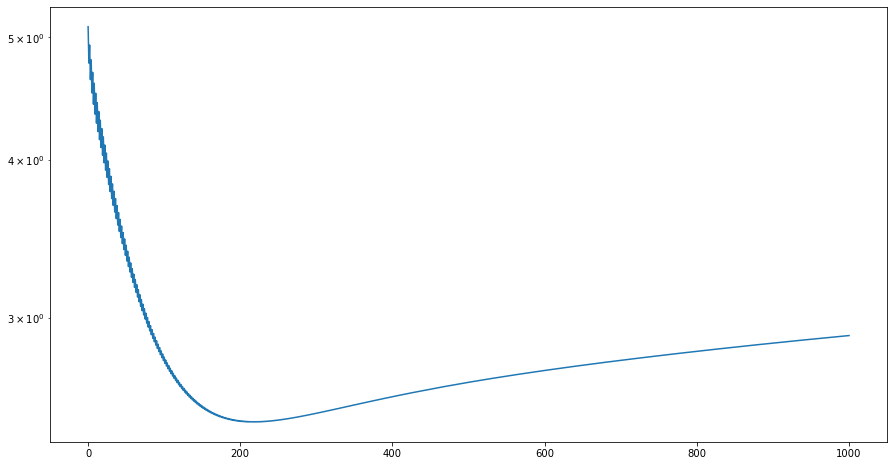

In [10]:
thetas = graph_dict[0.05][0]
plt.figure(figsize = (15,8))
test_losses = np.zeros(thetas.shape[0])
for i in range(thetas.shape[0]):
    
    theta = thetas [i,:]
    test_loss = compute_square_loss(X_test, y_test, theta)
    test_losses[i]= test_loss
    
plt.plot(step_array, test_losses)
plt.yscale('log')
#plt.xscale('log')

In [11]:
#######################################
### The gradient of regularized batch gradient descent
def compute_regularized_square_loss_gradient(X, y, theta, lambda_reg, stoch_flag = False):
    """
    Compute the gradient of L2-regularized average square loss function given X, y and theta

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)
        lambda_reg - the regularization coefficient

    Returns:
        grad - gradient vector, 1D numpy array of size(num_features)
    """
    #TODO
    
    grad = (2/X.shape[0])
    
    if stoch_flag == True:
        
        grad = grad *(X.T@X@theta - X.reshape(X.shape[1],).T*y)
        
    else:
        grad = grad*(X.T@X@theta - X.T@y)
    
    grad = grad +(2*lambda_reg*theta)
    
    return grad
    

In [12]:
### Regularized batch gradient descent
def regularized_grad_descent(X, y, alpha=0.05, lambda_reg=10**-2, num_step=1000):
    """
    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - step size in gradient descent
        lambda_reg - the regularization coefficient
        num_step - number of steps to run
    
    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size(num_step+1, num_features)
                     for instance, theta in step 0 should be theta_hist[0], theta in step(num_step+1) is theta_hist[-1]
        loss hist - the history of average square loss function without the regularization term, 1D numpy array.
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.zeros(num_features) #Initialize theta
    theta_hist = np.zeros((num_step+1, num_features)) #Initialize theta_hist
    loss_hist = np.zeros(num_step+1) #Initialize loss_hist
    #TODO
    
    loss_hist[0] = compute_square_loss(X,y,theta)
    theta_hist[0,:] = theta
    
    for i in range(1,num_step+1):
       
        grad = compute_regularized_square_loss_gradient(X,y,theta, lambda_reg)
        theta = theta - (alpha * grad)
        loss_hist[i] = compute_square_loss(X,y,theta)
        theta_hist[i,:] = theta
        
    return theta_hist, loss_hist


#######################################

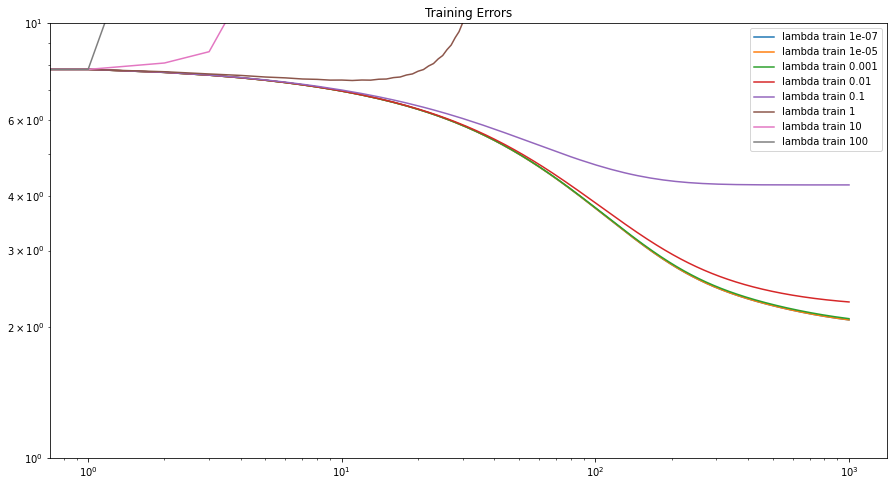

In [13]:
lambdas = [1e-7,1e-5,1e-3,1e-2,.1,1,10,100]
step_array = list(range(1001))
graph_dict = dict()

for lam in lambdas:
    graph_dict[lam] = [1,2,3]
    graph_dict[lam][0], graph_dict[lam][1]   = regularized_grad_descent(X_train, y_train, alpha = 0.05, lambda_reg = lam, num_step=1000)
    
    test_error = np.zeros(1001)
    for i in range(1001):
        
        theta = graph_dict[lam][0][i]
        testy = compute_square_loss(X_test, y_test,theta)
        test_error[i]=testy

    graph_dict[lam][2]=test_error
    
plt.figure(figsize = (15,8))
for key in lambdas[:]:
    
    plt.plot(step_array, graph_dict[key][1], label ="lambda train "+ str(key))
    plt.yscale('log') 
    plt.xscale("log")

plt.legend()
plt.title("Training Errors")
plt.show()

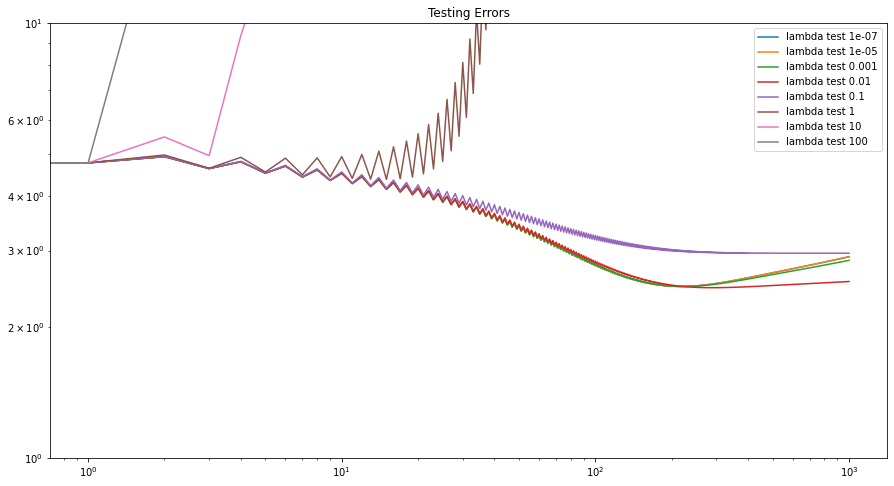

In [14]:
plt.figure(figsize = (15,8))
for key in lambdas[:]:
    
    plt.plot(step_array, graph_dict[key][2], label ="lambda test "+ str(key))
    plt.yscale('log') 
    plt.xscale("log")

plt.legend()
plt.title("Testing Errors")
plt.show()

1e-07 2.0777006144263 2.9034175759537213 2.479952363484436
1e-05 2.0778239254952298 2.902834530224267 2.4799379219810986
0.001 2.0913500007595984 2.847542512245566 2.4784998174321498
0.01 2.2847146705114065 2.5458029589010645 2.4635923135437956
0.1 4.245811582850459 2.957710971076267 2.957698067537791


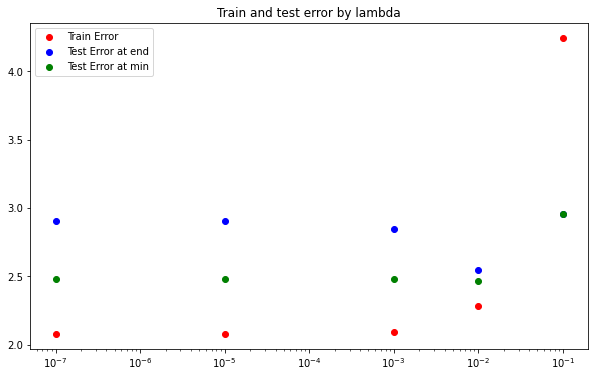

In [15]:
plt.figure(figsize = (10,6))

for lam in lambdas[:-3]:
    plt.scatter (lam, graph_dict[lam][1][-1], color = 'r')
    plt.scatter (lam, graph_dict[lam][2][-1], color = 'b')
    plt.scatter (lam, min(graph_dict[lam][2]), color = 'g')
    print(lam, graph_dict[lam][1][-1],graph_dict[lam][2][-1],min(graph_dict[lam][2]))
    
plt.title("Train and test error by lambda")
plt.legend(["Train Error","Test Error at end","Test Error at min"])
plt.xscale('log')
#plt.yscale('log')

In [16]:
# plt.figure(figsize = (10,6))

# for lam in lambdas:
#     plt.scatter(lam, min(graph_dict[lam][1]), color = 'r')
#     plt.scatter(lam, min(graph_dict[lam][2]), color = 'b')
#     print(lam, min(graph_dict[lam][1]),min(graph_dict[lam][2]))
    
# plt.title("Train and test error by lambda")
# plt.legend(["Train Error","Test Error"])
# plt.xscale('log')
# #plt.yscale('log')

In [17]:
### Stochastic gradient descent
def stochastic_grad_descent(X, y, alpha=0.01, lambda_reg=10**-2, num_epoch=1000, eta0=False, sched = "reg"):
    """
    In this question you will implement stochastic gradient descent with regularization term

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - string or float, step size in gradient descent
                NOTE: In SGD, it's not a good idea to use a fixed step size. Usually it's set to 1/sqrt(t) or 1/t
                if alpha is a float, then the step size in every step is the float.
                if alpha == "1/sqrt(t)", alpha = 1/sqrt(t).
                if alpha == "1/t", alpha = 1/t.
                
        lambda_reg - the regularization coefficient
        num_epoch - number of epochs to go through the whole training set

    Returns:
        theta_hist - the history of parameter vector, 3D numpy array of size(num_epoch, num_instances, num_features)
                     for instance, theta in epoch 0 should be theta_hist[0], theta in epoch(num_epoch) is theta_hist[-1]
        loss hist - the history of loss function vector, 2D numpy array of size(num_epoch, num_instances)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.ones(num_features) #Initialize theta

    theta_hist = np.zeros((num_epoch, num_instances, num_features)) #Initialize theta_hist
    loss_hist = np.zeros((num_epoch, num_instances)) #Initialize loss_hist
    
    for epoch in range(num_epoch):
        
        theta_hist[epoch,0,:] = theta 
        loss_hist[epoch,0] = compute_square_loss (np.array([X[0,:]]),y[0],theta, stoch_flag =True)
        
        for i in range(1, num_instances):
            
            if sched == "sqrt":
                alph_amend = alpha/np.sqrt(i)
            if sched == "dec":
                alph_amend = alpha/i
            else:
                alph_amend = alpha
        
            grad = compute_regularized_square_loss_gradient(np.array([X[i,:]]), y[i], theta, lambda_reg, stoch_flag = True)
            theta = theta - (alph_amend * grad)
            theta_hist[epoch,i,:] = theta
            loss_hist[epoch, i] = compute_square_loss(X[i,:], y[i], theta, lambda_reg)
        
    return theta_hist, loss_hist
        
        

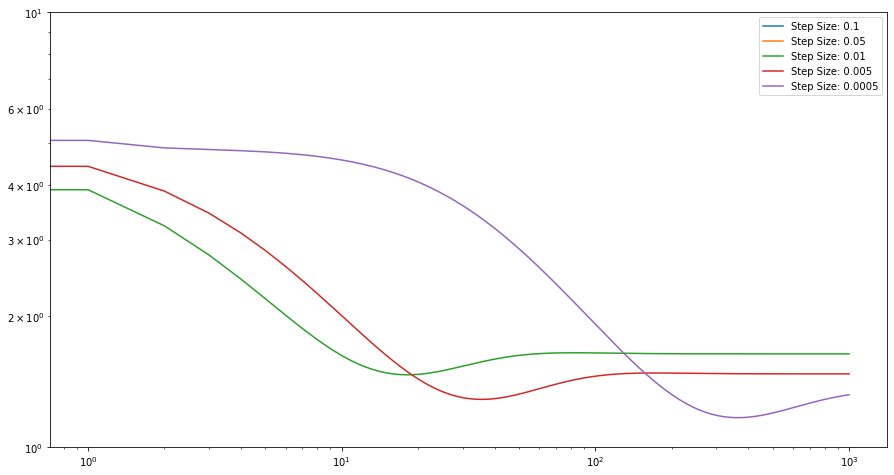

In [18]:
plt.figure(figsize = (15,8))
x = list(range(1000))
alpha_array = [0.1, 0.05, 0.01, 0.005, 0.0005]
error_array = []
theta_array = []

for a in alpha_array:
    
    theta_sub_lam, error_sub_lam = stochastic_grad_descent(X_train, y_train, alpha=a)
    error_array=(error_sub_lam[:,-1]) #choose last val of every epoch
    plt.plot(x, error_array, label = "Step Size: "+str(a))

plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()   
#print("The first 3 alphas diverge. We see that when the step size is decreased, square loss is more likely to be minimized after a larger number of epochs")



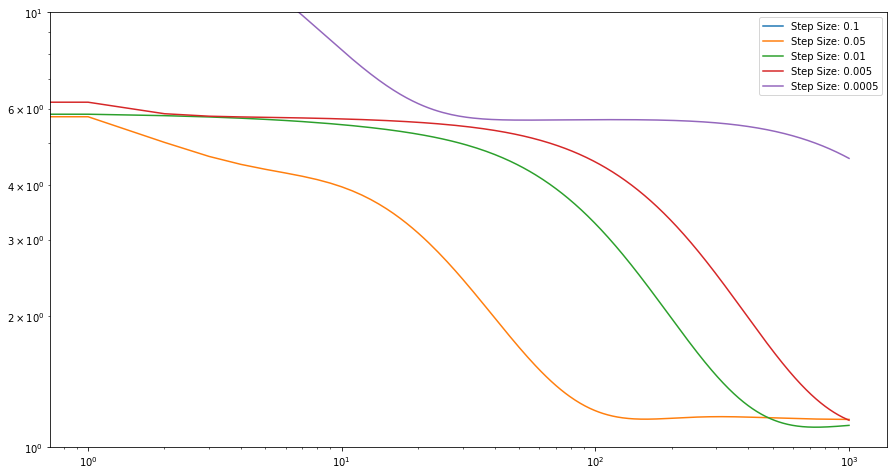

In [19]:
plt.figure(figsize = (15,8))
x = list(range(1000))
alpha_array = [0.1,0.05, 0.01, 0.005, 0.0005]
error_array = []
theta_array = []

for a in alpha_array:
    
    theta_sub_lam, error_sub_lam = stochastic_grad_descent(X_train, y_train, alpha=a, sched = "dec")
    error_array=(error_sub_lam[:,-1]) #choose last val of every epoch
    plt.plot(x, error_array, label = "Step Size: "+str(a))

plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show() 


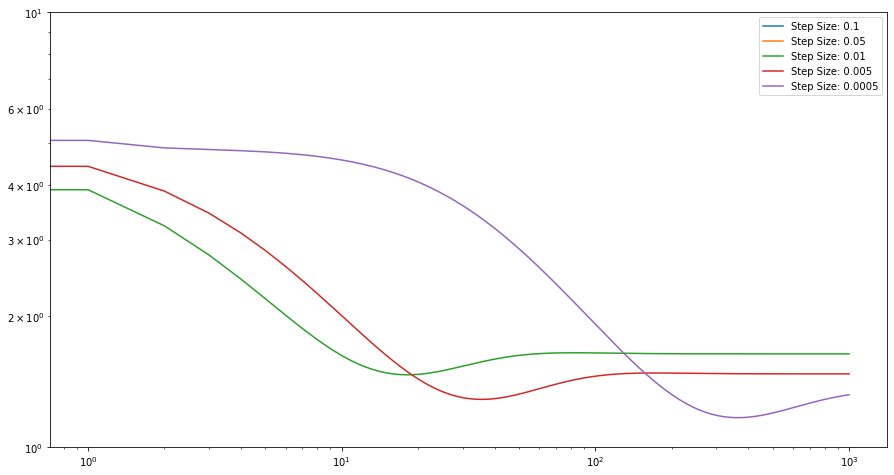

In [20]:
plt.figure(figsize = (15,8))
x = list(range(1000))
alpha_array = [0.1,0.05, 0.01, 0.005, 0.0005]
error_array = []
theta_array = []

for a in alpha_array:
    
    theta_sub_lam, error_sub_lam = stochastic_grad_descent(X_train, y_train, alpha=a, sched = "sqrt")
    error_array=(error_sub_lam[:,-1]) #choose last val of every epoch
    
    plt.plot(x, error_array, label = "Step Size: "+str(a))

plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [21]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def pre_process_mnist_01():
    """
    Load the mnist datasets, selects the classes 0 and 1 
    and normalize the data.
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    X_mnist, y_mnist = fetch_openml('mnist_784', version=1, 
                                    return_X_y=True, as_frame=False)
    indicator_01 = (y_mnist == '0') + (y_mnist == '1')
    X_mnist_01 = X_mnist[indicator_01]
    y_mnist_01 = y_mnist[indicator_01]
    X_train, X_test, y_train, y_test = train_test_split(X_mnist_01, y_mnist_01,
                                                        test_size=0.33,
                                                        shuffle=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_test = scaler.transform(X_test)

    y_test = 2 * np.array([int(y) for y in y_test]) - 1
    y_train = 2 * np.array([int(y) for y in y_train]) - 1
    return X_train, X_test, y_train, y_test


def sub_sample(N_train, X_train, y_train):
    """
    Subsample the training data to keep only N first elements
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    assert N_train <= X_train.shape[0]
    return X_train[:N_train, :], y_train[:N_train]

#def classification_error(clf, X, y):
    ## TODO


X_train, X_test, y_train, y_test = pre_process_mnist_01()

clf = SGDClassifier(loss='log', max_iter=1000, 
                    tol=1e-3,
                    penalty='l1', alpha=0.01, 
                    learning_rate='invscaling', 
                    power_t=0.5,                
                    eta0=0.01,
                    verbose=1)
clf.fit(X_train, y_train)

# test = classification_error(clf, X_test, y_test)
# train = classification_error(clf, X_train, y_train)
# print('train: ', train, end='\t')
# print('test: ', test)

-- Epoch 1
Norm: 0.68, NNZs: 281, Bias: 0.003332, T: 9902, Avg. loss: 0.041707
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 0.77, NNZs: 255, Bias: 0.003157, T: 19804, Avg. loss: 0.031715
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 0.83, NNZs: 246, Bias: 0.003321, T: 29706, Avg. loss: 0.030206
Total training time: 0.11 seconds.
-- Epoch 4
Norm: 0.88, NNZs: 238, Bias: 0.003603, T: 39608, Avg. loss: 0.029431
Total training time: 0.15 seconds.
-- Epoch 5
Norm: 0.92, NNZs: 225, Bias: 0.003915, T: 49510, Avg. loss: 0.028740
Total training time: 0.19 seconds.
-- Epoch 6
Norm: 0.95, NNZs: 223, Bias: 0.004267, T: 59412, Avg. loss: 0.028386
Total training time: 0.23 seconds.
-- Epoch 7
Norm: 0.98, NNZs: 217, Bias: 0.004636, T: 69314, Avg. loss: 0.028054
Total training time: 0.26 seconds.
-- Epoch 8
Norm: 1.01, NNZs: 214, Bias: 0.005013, T: 79216, Avg. loss: 0.027821
Total training time: 0.30 seconds.
Convergence after 8 epochs took 0.30 seconds


SGDClassifier(alpha=0.01, eta0=0.01, learning_rate='invscaling', loss='log',
              penalty='l1', verbose=1)

In [22]:
def classification_error(classifier, X, y):
    
    '''
    Takes trained classifier and computes classification error
    Since all values are 1 or -1, we can subtract and sum to get toal 
    number of misclassifications
    
    X must be at least 2 rows, otherwise need to reshape
    '''
            
    return sum(abs(classifier.predict(X)-y))/(2*len(y))
        

In [23]:
def create_error_by_alpha (X_train, y_train, X_test, y_test, alpha_array, repeat_times):
    
    #errArray = np.zeros(len(alpha_array)*repeat_times)
    means=list()
    stds = list()
    coeffs = list()
    
    for j in range(len(alpha_array)):
        
        small_array = np.zeros(10)
        
        clf = SGDClassifier(loss='log', max_iter=1000, 
                    tol=1e-3,
                    penalty='l1', alpha=alpha_array[j], 
                    learning_rate='invscaling', 
                    power_t=0.5,                
                    eta0=0.01,
                    verbose=0)
        
        for i in range(repeat_times):
            
            train_x, train_y = sub_sample(100, X_train, y_train)
            clf.fit(train_x, train_y)
            #errArray[(j*10)+i]=classification_error(clf, X_test, y_test)
            small_array[i]=classification_error(clf, X_test, y_test)
            
            if i ==0:
                coeffs.append(clf.coef_)
        
        mean = np.mean(small_array)
        std = np.std(small_array)
        means.append(mean)
        stds.append(std)
        
    return means, stds, np.array(coeffs)
        

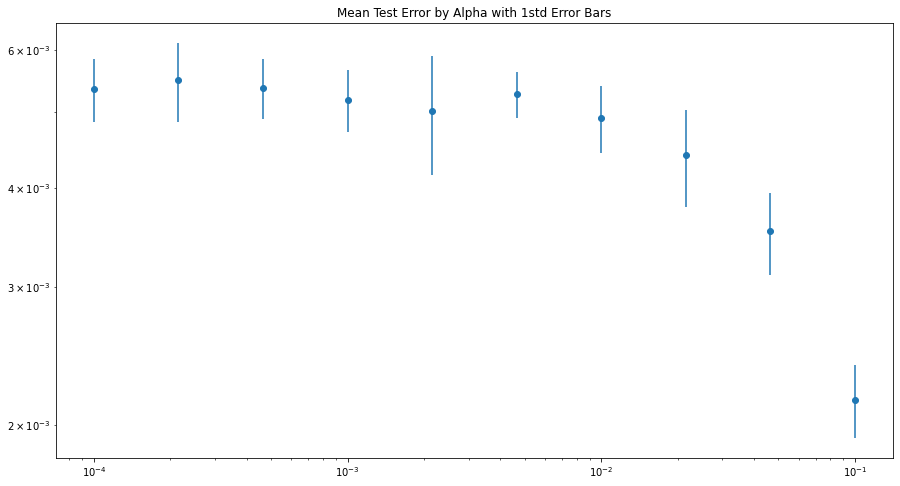

In [24]:
alpha_array = np.logspace(-4,-1, num =10)
means, stds, coeffs = create_error_by_alpha (X_train, y_train, X_test, y_test,alpha_array,10)

# for item in alpha_array:
    
#     shortlist = [i-i+item for i in range(10)]
#     x = x+ shortlist

plt.figure(figsize = (15,8))
plt.errorbar(alpha_array,means,yerr = stds, fmt = 'o')
plt.yscale("log")
plt.title("Mean Test Error by Alpha with 1std Error Bars")
plt.xscale('log')
plt.show()



In [25]:
coeffs_array = []
#plt.figure(figsize=[15,50])
#fig, axs = plt.subplots(10)
for alpha in range(coeffs.shape[0]):
    
    big_array = coeffs[alpha][0]
    reshaped_array = big_array.reshape(28,28)
    coeffs_array.append(reshaped_array)
    print("Alpha "+str(alpha_array[alpha])+" L1 norm: "+str(sum(abs(big_array))))
    
    #axs[alpha].imshow(reshaped_array)
    

    


Alpha 0.0001 L1 norm: 8.05552147823788
Alpha 0.00021544346900318845 L1 norm: 8.20606007945342
Alpha 0.00046415888336127773 L1 norm: 8.00121748703785
Alpha 0.001 L1 norm: 7.870158033770893
Alpha 0.002154434690031882 L1 norm: 7.608805716246144
Alpha 0.004641588833612777 L1 norm: 7.187250888163917
Alpha 0.01 L1 norm: 6.26036478943223
Alpha 0.021544346900318822 L1 norm: 5.141899074317786
Alpha 0.046415888336127774 L1 norm: 3.519663047735944
Alpha 0.1 L1 norm: 2.160067077601991


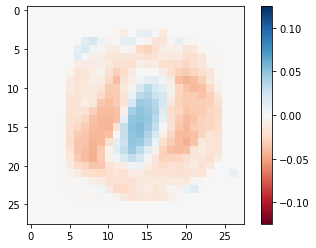

In [26]:
scale = np.abs(clf.coef_).max()
plt.imshow(coeffs_array[0], cmap=plt.cm.RdBu, vmax=scale, vmin=-scale )
plt.colorbar()
plt.show()

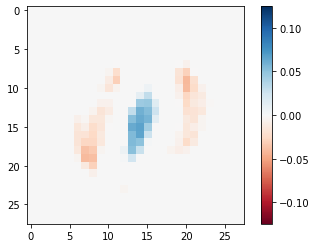

In [27]:
plt.imshow(coeffs_array[9], cmap=plt.cm.RdBu, vmax=scale, vmin=-scale )
plt.colorbar()
plt.show()